# Multi-Layer Perceptron

## Libraries

In [183]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Data

In [184]:
data = pd.read_csv("../data/parsed_data.csv", index_col = [0]) 

In [185]:
X = data.drop(columns=['Label','Transcript ID','Position','N1','N2','N3'])
y = data['Label']
groups = data['Gene ID']

gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=21)

for train_idx, test_idx in gss.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

X_train = X_train.drop(columns=['Gene ID'])
X_test = X_test.drop(columns=['Gene ID'])

Oversampling.

In [186]:
smote = SMOTE(random_state=21)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled class distribution: {Counter(y_train_resampled)}")


Resampled class distribution: Counter({0: 79775, 1: 79775})


Normalise the features for training.

In [187]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [188]:
X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train_resampled)
X_test_scaled = np.array(X_test_scaled)
y_test = np.array(y_test)

In [189]:
# Convert X_train_scaled and y_train to the correct data types
X_train_scaled = X_train_scaled.astype(np.float32)
y_train = y_train.astype(np.int32)

X_test_scaled = X_test_scaled.astype(np.float32)
y_test = y_test.astype(np.int32)

In [190]:
print(f"X_train_scaled type: {type(X_train_scaled)}, shape: {X_train_scaled.shape}")
print(f"y_train type: {type(y_train)}, shape: {y_train.shape}")
print(f"X_test_scaled type: {type(X_test_scaled)}, shape: {X_test_scaled.shape}")
print(f"y_test type: {type(y_test)}, shape: {y_test.shape}")

print("Sample X_train_scaled:", X_train_scaled[:5])
print("Sample y_train:", y_train[:5])

X_train_scaled type: <class 'numpy.ndarray'>, shape: (159550, 36)
y_train type: <class 'numpy.ndarray'>, shape: (159550,)
X_test_scaled type: <class 'numpy.ndarray'>, shape: (38298, 36)
y_test type: <class 'numpy.ndarray'>, shape: (38298,)
Sample X_train_scaled: [[-0.48441374  0.03863708 -0.31352714 -0.9036463  -0.7502455  -1.4436986
   0.6973084  -0.8462286  -0.29962996 -0.12759268 -0.43068925 -0.2566307
  -0.24277073 -0.11225363 -0.2822862  -0.25401944 -1.2361332  -0.9208946
  -1.37739    -1.1135954  -0.42680058 -0.43915328 -0.57568485 -0.31944036
  -0.02775729  0.86953694 -0.84322774  0.6522916  -1.2980702  -1.2340497
  -1.1247237  -1.1702474   1.6337053   1.88343     1.2326434   1.6122681 ]
 [ 0.48065835 -0.7091969  -0.10781233  0.65845096 -0.22856368 -0.505494
   0.48244888 -0.25397605  0.64219916  0.8348387   0.4120493   0.649262
  -0.4780091  -0.11225363 -1.0181845   0.01084011  0.41790253 -0.57084703
   0.25192124  0.3790412   0.8854481   0.8887347   0.56440246  0.9056961
  -0.

## Model

In [202]:
model = Sequential()

# Input layer with 128 units and ReLU activation
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3))

# Hidden layer 1 with 64 units
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Hidden layer 2 with 32 units
model.add(Dense(32, activation='relu'))

# Hidden layer 3 with 16 units
model.add(Dense(16, activation='relu'))

# Output layer (binary classification, so use sigmoid)
model.add(Dense(1, activation='sigmoid'))

/Users/arnoldlek/Desktop/DSA4262/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [203]:
input_shape = X_train_scaled.shape[1]
print(f"Input shape: {input_shape}")

Input shape: 36


### Compiling

In [204]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


### Training

In [205]:
history = model.fit(X_train_scaled, y_train, 
    validation_data=(X_test_scaled, y_test), 
    epochs=50, 
    batch_size=32, 
    callbacks=[early_stopping])

Epoch 1/50
4986/4986 ━━━━━━━━━━━━━━━━━━━━ 4s 671us/step - accuracy: 0.5483 - loss: 0.6874 - precision: 0.5570 - recall: 0.5008 - val_accuracy: 0.7257 - val_loss: 0.6661 - val_precision: 0.0659 - val_recall: 0.3901
Epoch 2/50
4986/4986 ━━━━━━━━━━━━━━━━━━━━ 3s 666us/step - accuracy: 0.6008 - loss: 0.6588 - precision: 0.6340 - recall: 0.4712 - val_accuracy: 0.6559 - val_loss: 0.6816 - val_precision: 0.0600 - val_recall: 0.4573
Epoch 3/50
4986/4986 ━━━━━━━━━━━━━━━━━━━━ 3s 590us/step - accuracy: 0.6226 - loss: 0.6437 - precision: 0.6468 - recall: 0.5363 - val_accuracy: 0.5820 - val_loss: 0.6982 - val_precision: 0.0545 - val_recall: 0.5111
Epoch 4/50
4986/4986 ━━━━━━━━━━━━━━━━━━━━ 3s 695us/step - accuracy: 0.6386 - loss: 0.6307 - precision: 0.6519 - recall: 0.5922 - val_accuracy: 0.6046 - val_loss: 0.6877 - val_precision: 0.0552 - val_recall: 0.4877
Epoch 5/50
4986/4986 ━━━━━━━━━━━━━━━━━━━━ 3s 598us/step - accuracy: 0.6516 - loss: 0.6202 - precision: 0.6635 - recall: 0.6211 - val_accuracy: 0

1197/1197 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
AUC Score: 0.5805


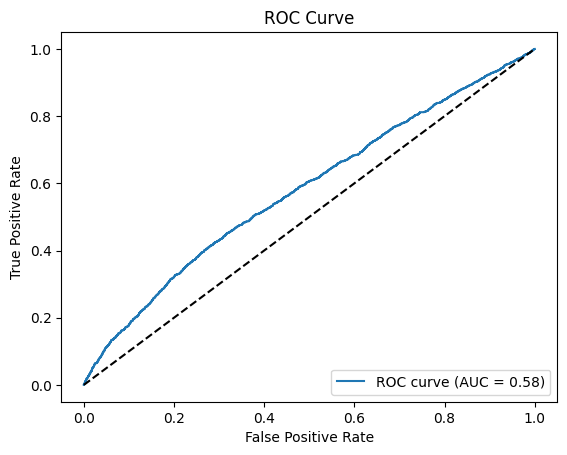

Text(0.5, 1.0, 'Confusion Matrix for QDA')

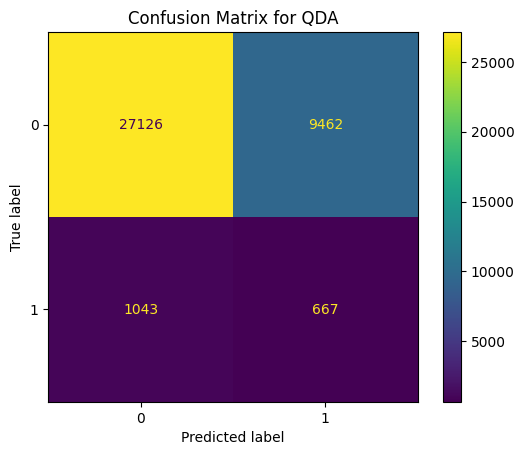

In [206]:
# Predict probabilities for the test set
y_pred_proba = model.predict(X_test_scaled)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
y_pred_class = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to class labels
cm = confusion_matrix(y_test, y_pred_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.title('Confusion Matrix for QDA')